<h1>Take Home Challenge 1: Ultimate Technologies, Inc.</h1>
<h2>Springboard Data Science Career Track</h2>

My responses labeled

<h3>Data description</h3>
<ul>
<li><b>city:</b> city this user signed up in</li>
<li><b>phone:</b> primary device for this user</li>
<li><b>signup_date:</b> date of account registration; in the form ‘YYYY MM DD’</li>
<li><b>last_trip_date:</b> the last time this user completed a trip; in the form ‘YYYY MM DD’</li>
<li><b>avg_dist:</b> the average distance in miles per trip taken in the first 30 days after signup</li>
<li><b>avg_rating_by_driver:</b> the rider’s average rating over all of their trips</li>
<li><b>avg_rating_of_driver:</b> the rider’s average rating of their drivers over all of their trips</li>
<li><b>surge_pct:</b> the percent of trips taken with surge multiplier > 1</li>
<li><b>avg_surge:</b> The average surge multiplier over all of this user’s trips</li>
<li><b>trips_in_first_30_days:</b> the number of trips this user took in the first 30 days after signing up</li>
<li><b>ultimate_black_user:</b> TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise</li>
<li><b>weekday_pct:</b> the percent of the user’s trips occurring during a weekday</li>
</ul>

<h3>Part 1: Exploratory Data Analysis</h3>

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15-minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [3]:
import pandas as pd
import seaborn as sns

logdf = pd.read_json('logins.json')
logdf.set_index('login_time', inplace=True)
logdf.head()

""
login_time
1970-01-01 20:13:18
1970-01-01 20:16:10
1970-01-01 20:16:37
1970-01-01 20:16:36
1970-01-01 20:26:21


In [2]:
logdf.shape

(93142, 0)

<b>(Me)</b> Looks like we have 93,000 logins. Year is not being recorded correctly, and month might not be either, but <i>relative</i> days should be fine—we have 102 consecutive days from the day labeled "Jan 1" to the day labeled "Apr 13". Another issue is that the first and last days are incomplete. We can drop them to get 100 full days if needed.

In [3]:
logdf['count'] = 1
logdf15min = logdf.resample('15min').count()
logdf15min.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [4]:
logdf15min.shape

(9788, 1)

Text(0.5, 1.0, 'Logins by Time of Day for Jan 2')

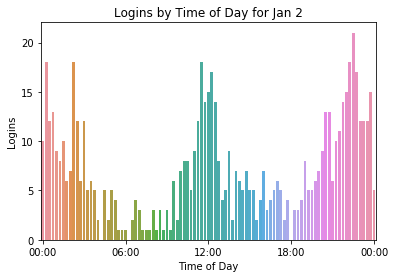

In [5]:
# Graph the first full day
day2df = logdf15min.iloc[16:113]

ax = sns.barplot(x=day2df.index, y='count', data=day2df)
ax.set_xlabel("Time of Day")
ax.set_ylabel("Logins")
ax.set_yticks([5*i for i in range(5)])
ax.set_xticks([24*i for i in range(5)])
ax.set_xticklabels(['00:00', '06:00', '12:00', '18:00', '00:00'])
ax.set_title("Logins by Time of Day for Jan 2")

<b>(Me)</b> From this graph, it appears there are two main demand peaks, in line with my intuition (morning commute and evenings). Based the incorrectly labeled year coupled with the awkward peak times seen here, I would assume what is currently labeled 6:00 AM is actually around 2:00 AM.

We'll need to take summary statistics across days to see if there is a pattern.

Text(0.5, 1.0, "Average Day's Demand Cycle")

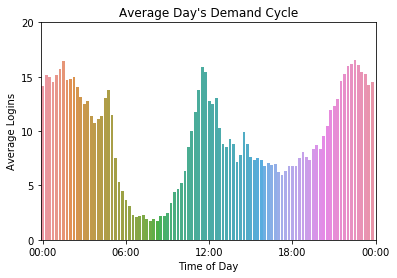

In [6]:
# Determining the Average Day
# Group by time of day across all days, take the average demand

logdf_group_tod = logdf15min.copy(deep=True)
logdf_group_tod['time_of_day'] = logdf_group_tod.index.strftime('%H:%M')

tod_mean = logdf_group_tod.groupby('time_of_day').mean()

ax = sns.barplot(x=tod_mean.index, y='count', data=tod_mean)
ax.set_xlabel("Time of Day")
ax.set_ylabel("Average Logins")
ax.set_yticks([5*i for i in range(5)])
ax.set_xticks([24*i for i in range(5)])
ax.set_xticklabels(['00:00', '06:00', '12:00', '18:00', '00:00'])
ax.set_title("Average Day's Demand Cycle")

<b>(Me)</b> January 2 proved to be a fairly average day. It's probably correct that what's currently labeled as 6:00AM is an early morning hour, because we clearly see that midnight-to-midnight is in the middle of a demand peak. That assumption means we see steady demand in all daylight hours, with a peak during morning commute and all throughout the active evening hours.

Text(0.5, 1.0, "Average Week's Demand Cycle")

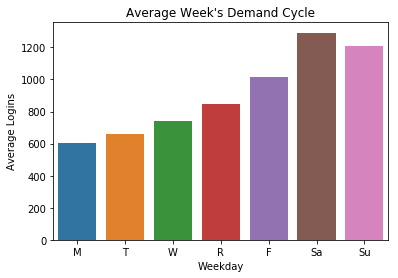

In [7]:
# Determining the Average Week
# Group by day across all, take the average demand


logdf['count'] = 1
logdf_byday = logdf.resample('D').count()
logdf_byday = logdf_byday.iloc[1:-1]

logdf_byday['weekday'] = logdf_byday.index.weekday

wk_mean = logdf_byday.groupby('weekday').mean()

ax = sns.barplot(x=wk_mean.index, y='count', data=wk_mean)
ax.set_xlabel("Weekday")
ax.set_ylabel("Average Logins")
ax.set_xticklabels(["M", "T", "W", "R", "F", "Sa", "Su"])
ax.set_title("Average Week's Demand Cycle")

<b>(Me)</b> Demand is lowest on Monday, rising throughout the week to a peak on Saturday and Sunday to a heavy drop on Monday. Seems like they are labeled correctly. This could correspond with weekend tourism, perhaps.

Text(0.5, 1.0, 'Logins per Day')

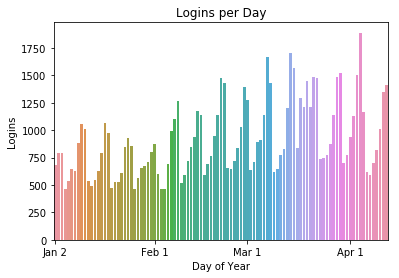

In [8]:
# Graph the period by day to see if there is seasonality

ax = sns.barplot(x=logdf_byday.index, y='count', data=logdf_byday)
ax.set_xlabel("Day of Year")
ax.set_ylabel("Logins")
ax.set_xticks([0, 30, 58, 89])
ax.set_xticklabels(['Jan 2', 'Feb 1', 'Mar 1', 'Apr 1'])
ax.set_title("Logins per Day")

<b>(Me)</b> Clearly demand is cyclical by week, but we are also observing an overall upward trend across the observation period. This could be seasonality but it could also be the app gaining popularity over time.

<h3>Part 2: Experiment and Metrics Design</h3>

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

    a. how you will implement the experiment
    
    b. what statistical test(s) you will conduct to verify the significance of the observation
    
    c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.

<h4>My Responses to Part 2</h4>

1. <b>For my key metric of success, I would choose mean wait time of all rides in both cities.</b> This is what we are ultimately trying to minimize with this initiative to increase operations in both metropolitan areas. This metric is simple, easy to track, and it should be pretty sensitive to our desired condition—if either city is under-served, our metric will detect the increase in median wait time. One potential issue is that riders get a predicted wait time, so the ones that see the longest waits might be self-selecting out of the model. We could fix this by targeting median predicted wait time, but that chases a different goal (we just want driver crossover for this experiment).


2. <b>Designing the Experiment</b>

    a. <b>We should select a control week during which to gather data, and then the following week, implement our experimental condition: reimbursement of toll costs for some proportion (e.g. 20%) of drivers.</b> (Importantly, we cannot divide the drivers into experiment and control because they are concurrently pulling from the same rider base. There's no way for the "control" group to be unaffected by the behavior of the experimental group.) Harvesting our target variable will be easy; just check the time between when a ride is called and when it arrives. This design leaves us sensitive to lurking variables that change over time, so we should check each city's schedule and pick weeks where no special events will affect our observation, make sure the marketing team has no outstanding promotionals, and account for any seasonality or growing popularity in the statistical tests.
    
    b. We will run a difference of means between the experimental week and the control week. Importantly, our test is senstivite to outliers, so we should check to make sure no outliers unnecessarily cloud our results. We should also make sure that we account for any seasonality—this should not be a problem if we select two very similar weeks. Then we create a confidence interval and check to see if zero is in the confidence interval. If zero is within our confidence interval, that means one of our best guesses for the increase from Week 1 to Week 2 is <i>no increase at all,</i> so we would have no reason to move forward with this change.
    
    c. If we see a significant change in favor of Week 2, that signals evidence to implement a new policy, but not without reservations. Once we begin reimbursing tolls, drivers will be incentivized to test out a new driving pattern to see if it's worth their effort. If we roll out this change to all drivers at once, a tragedy of the commons could happen: all drivers test out the new route at once, plummet each other's profits, and learn that crossing cities has no reward. I would recommend rolling this out in phases. "Grandfather in" the drivers who participated in the experiment by extending their toll reimbursements indefinitely. This will allow us to gradually add confidence in the drivers' long-term reaction to the reimbursed tolls, and it will also allow us to slowly increase the proportion of reimbursed drivers until we achieve our desired wait time.

<h3>Part 3: Predictive Modeling</h3>

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

In [4]:
# Pandas wasn't wanting to load this correctly

import json
with open('ultimate_data_challenge.json') as file:
    data = json.load(file)
df = pd.DataFrame(data)

df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [5]:
df.dtypes

avg_dist                  float64
avg_rating_by_driver      float64
avg_rating_of_driver      float64
avg_surge                 float64
city                       object
last_trip_date             object
phone                      object
signup_date                object
surge_pct                 float64
trips_in_first_30_days      int64
ultimate_black_user          bool
weekday_pct               float64
dtype: object

In [6]:
# Convert datetime columns to datetime, then determine target range
signups = pd.to_datetime(df['signup_date'])
df['signup_date'] = [entry.day for entry in signups]
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

print(df['last_trip_date'].max())

2014-07-01 00:00:00


In [7]:
# Create the target variable, 'retained', and drop the column it came from
df['retained'] = 0
df.loc[df['last_trip_date'].dt.month >= 6, 'retained'] = 1
df.drop('last_trip_date', axis=1, inplace=True)

# One hot encode all the categorical features
dummiescols = ['city', 'phone', 'ultimate_black_user']
df = pd.get_dummies(df, prefix=dummiescols, columns=dummiescols, drop_first=True)

df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,signup_date,surge_pct,trips_in_first_30_days,weekday_pct,retained,city_King's Landing,city_Winterfell,phone_iPhone,ultimate_black_user_True
0,3.67,5.0,4.7,1.10,25,15.4,4,46.2,1,1,0,1,1
1,8.26,5.0,5.0,1.00,29,0.0,0,50.0,0,0,0,0,0
2,0.77,5.0,4.3,1.00,6,0.0,3,100.0,0,0,0,1,0
3,2.36,4.9,4.6,1.14,10,20.0,9,80.0,1,1,0,1,1
4,3.13,4.9,4.4,1.19,27,11.8,14,82.4,0,0,1,0,0


In [8]:
df['retained'].value_counts()

0    31196
1    18804
Name: retained, dtype: int64

In [9]:
pct_retained = round(18804/(18804+31196) * 100, 2)
print(f'{pct_retained}% of users were retained.')

37.61% of users were retained.


2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

<b>(Me)</b> Since this is a binomial classification problem, the most sensible first approach is logistic regression. This model is the easiest to interpret—it directly ranks the importance of the features by assigning them coefficient values. The bigger the magnitude of the coefficient, the more important the feature.

Other suitable models include XGBClassifier (a random forest ensemble method), K Nearest Neighbors, Naive Bayes Classifier, or even a Reinforcement Learning Classifier.</font>

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
import numpy as np

np.random.seed(0)

target = df['retained']
features = df.drop('retained', axis=1)
features.fillna('0', inplace=True)
features['avg_rating_by_driver'] = features['avg_rating_by_driver'].astype('float64')
features['avg_rating_of_driver'] = features['avg_rating_of_driver'].astype('float64')

X_train, X_test, y_train, y_test = train_test_split(features, target)

In [11]:
lr = LogisticRegressionCV(solver='liblinear', cv=10)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.72648

In [12]:
cols = [col for col in features.columns]
coefs = [round(coef, 2) for coef in lr.coef_[0]]
coefficients = zip(cols, coefs)

print(list(coefficients))

[('avg_dist', -0.03), ('avg_rating_by_driver', -0.11), ('avg_rating_of_driver', 0.12), ('avg_surge', -0.2), ('signup_date', -0.01), ('surge_pct', 0.0), ('trips_in_first_30_days', 0.11), ('weekday_pct', -0.0), ("city_King's Landing", 1.67), ('city_Winterfell', 0.53), ('phone_iPhone', 1.09), ('ultimate_black_user_True', 0.87)]


In [17]:
from sklearn.metrics import confusion_matrix

y_pred = lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[6748 1060]
 [2359 2333]]


<b>(Me)</b> Our first model lacks in both precision and recall. However, it does give us some insights about the key indicators, particulary when it comes to the dummy variables. Being from King's Landing, using an iPhone, and using Ultimate Black were the most important predictors. Next, I'll try an XGBClassifier: much more of a "black box", but a lot more accurate.

In [18]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb = XGBClassifier()

param_grid = {'max_depth': [2, 3, 4, 5],
              'learning_rate': [0.5, 0.1, 0.2],
              'n_estimators': [30, 100, 300]}

xgb_grid = GridSearchCV(xgb, param_grid=param_grid, cv=3)

xgb_grid.fit(X_train, y_train)
xgb_grid.score(X_test, y_test)

0.79784

In [19]:
xgb_grid.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}

In [20]:
xgb = XGBClassifier(learning_rate=0.1, max_depth=4, n_estimators=300)
xgb.fit(X_train, y_train)

cols = [col for col in features.columns]
weights = [round(weight, 2) for weight in xgb.feature_importances_]
importances = zip(cols, weights)

print(list(importances))

[('avg_dist', 0.01), ('avg_rating_by_driver', 0.18), ('avg_rating_of_driver', 0.02), ('avg_surge', 0.01), ('signup_date', 0.01), ('surge_pct', 0.11), ('trips_in_first_30_days', 0.03), ('weekday_pct', 0.06), ("city_King's Landing", 0.2), ('city_Winterfell', 0.05), ('phone_iPhone', 0.18), ('ultimate_black_user_True', 0.14)]


In [23]:
y_pred2 = xgb.predict(X_test)
cm2 = confusion_matrix(y_test, y_pred2)
print(cm2)

[[6837  971]
 [1556 3136]]


<b>(Me)</b> We have a much more accurate model now (80%), but the confusion is still high.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

<b>(Me)</b> Our model identified a few important predictors that increased likelihood of retention:
<ul>
<li>The average rating of the user by drivers</li>
<li>Whether the user faced surge pricing often</li>
<li>Whether the user was in King's Landing</li>
<li>Whether the user was on an iPhone instead of Android</li>
<li>Whether the user tried/used Ulitmate Black</li>
</ul>
    
For each of these, we could brainstorm hypotheses about how to use these insights to bump our retention rate:

<ul>
<li>Thanking new users when their driver gives them a good rating (if sociability is behind the rating-retention correlation)</li>
<li>Spoofing new users to have 5 stars for their first ~10 rides (if it's the case that a low first rating deters users or deters drivers from picking them up)</li>
<li>Insulating new users from surge pricing, then easing them into the system, or explaining why surge pricing is important</li>
<li>Getting new users to try Ulitmate Black</li>
<li>Ad campaigns more directly targeted to a mid-to-upper tier riders (income may be correlated to King's Landing, iPhones, and Ultimate Black)</li>
</ul>
</font>